<a href="https://colab.research.google.com/github/pammelaAC/MachineLearningPractitioner/blob/main/SistemaRecomendacaoimagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
%%writefile kaggle.json
{"username":"x","key":"x"}

Writing kaggle.json


In [7]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=5fa4b81949c01aad7c4b536d083db38d434924d15c284ba88716c1f7fabf5160
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [8]:
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [9]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','articleType']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
# Salvando imagens apenas de 4 categorias
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['articleType']
    category = str(list(category)[0])
    allowed_category = ['Tshirts','Casual Shoes','Handbags',"Perfume and Body Mist"]
    if category not in allowed_category:
        continue
        category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:23<00:00, 218.84it/s]

Moved 12288 images.


In [10]:
import os
import random
import shutil
# Extração de características estava demorando muito, então reduzi o número total de imagens
source_dir = '/content/Fashion_data/categories'
destination_dir = '/content/imgs/'
max_images_per_category = 500

os.makedirs(destination_dir, exist_ok=True)

for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)

    if not os.path.isdir(category_path):
        continue

    images = [img for img in os.listdir(category_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Selecionar aleatoriamente até 500 imagens
    selected_images = random.sample(images, min(len(images), max_images_per_category))

    # # Criar subdiretório no destino
    destination_category_path = os.path.join(destination_dir, category)
    os.makedirs(destination_category_path, exist_ok=True)

    # Mover imagens selecionadas
    for image in selected_images:
        shutil.move(os.path.join(category_path, image), os.path.join(destination_category_path, image))

    print(f"Movidas {len(selected_images)} imagens da categoria {category}.")

print("Processo concluído!")

Movidas 500 imagens da categoria Tshirts.
Movidas 500 imagens da categoria Perfume and Body Mist.
Movidas 500 imagens da categoria Handbags.
Movidas 500 imagens da categoria Casual Shoes.
Processo concluído!


In [11]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
Hub version: 0.16.1
GPU is available


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors

# Carregar modelo pré-treinado (sem camada final)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

In [13]:
# Função para extrair características da imagem
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    # Preprocessa input para rede vgg16
    img_data = preprocess_input(img_data)

    # Extrai as características e as achata para um vetor 1D
    features = model.predict(img_data)
    return features.flatten()

# Diretório com as imagens do conjunto de dados
image_dir = "/content/imgs/"


# Lista para armazenar caminhos e vetores de características
image_paths = []
image_vectors = []

# Percorrer todas as subpastas dentro de `image_dir`
for category in os.listdir(image_dir):
    category_path = os.path.join(image_dir, category)

    # Verificar se é um diretório
    if not os.path.isdir(category_path):
        continue

    # Listar imagens da categoria
    images = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.png'))]

    # Processar e extrair características de cada imagem
    for img in images:
        img_path = os.path.join(category_path, img)
        features = extract_features(img_path, model)
        image_paths.append(img_path)
        image_vectors.append(features)

# Converter para array numpy
image_vectors = np.array(image_vectors)

# Salvar as características e os caminhos das imagens
np.save('image_vectors.npy', image_vectors)
np.save('image_paths.npy', image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━

In [14]:
def find_similar_images(query_image_path, image_vectors, image_paths, top_n=5):
    query_vector = extract_features(query_image_path, model).reshape(1, -1)

    # Usar KNN para encontrar as mais similares
    knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
    knn.fit(image_vectors)
    distances, indices = knn.kneighbors(query_vector)

    # Retornar os caminhos das imagens mais similares
    similar_images = [image_paths[idx] for idx in indices.flatten()]
    return similar_images

# Função para exibir imagens
def show_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, len(image_paths), i + 1)
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


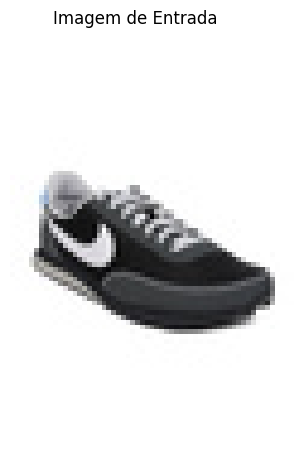

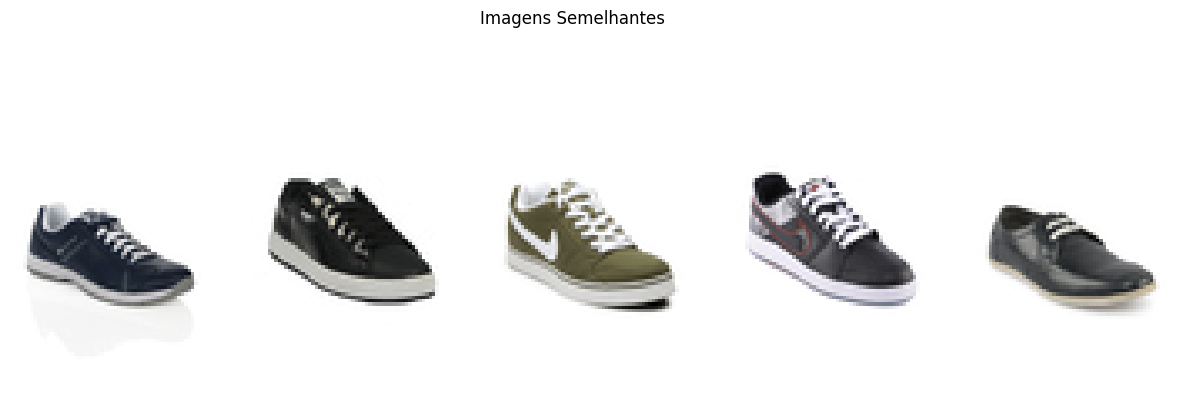

In [15]:
query_image = "/content/Fashion_data/categories/Casual Shoes/10640.jpg"
similar_images = find_similar_images(query_image, image_vectors, image_paths)

show_images([query_image], "Imagem de Entrada")
show_images(similar_images, "Imagens Semelhantes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


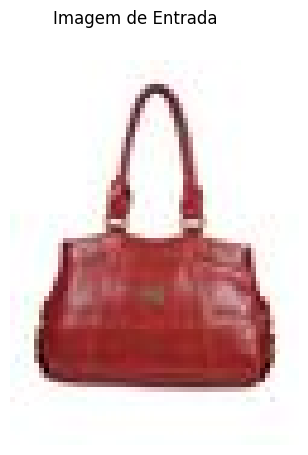

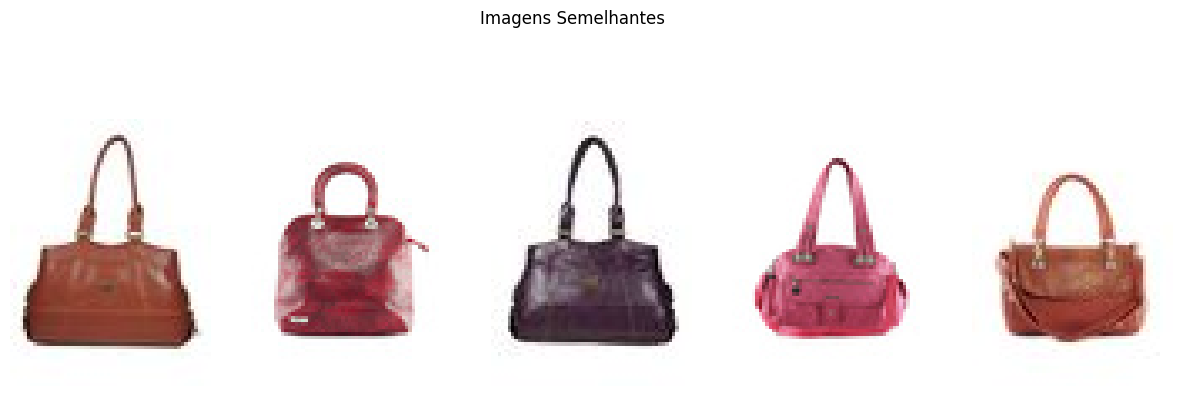

In [16]:
query_image = "/content/Fashion_data/categories/Handbags/10203.jpg"
similar_images = find_similar_images(query_image, image_vectors, image_paths)

show_images([query_image], "Imagem de Entrada")
show_images(similar_images, "Imagens Semelhantes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


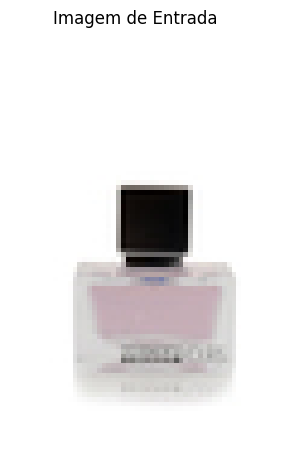

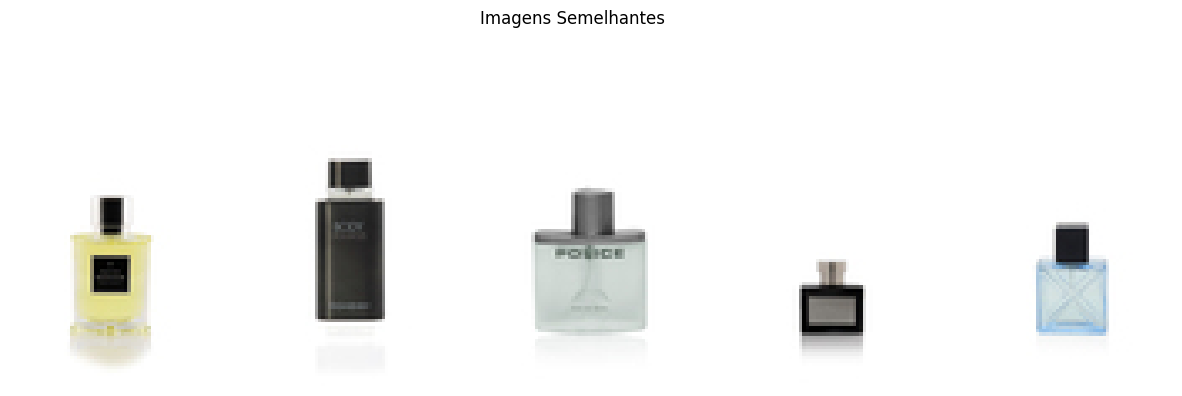

In [17]:
query_image = "/content/Fashion_data/categories/Perfume and Body Mist/18464.jpg"
similar_images = find_similar_images(query_image, image_vectors, image_paths)

show_images([query_image], "Imagem de Entrada")
show_images(similar_images, "Imagens Semelhantes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


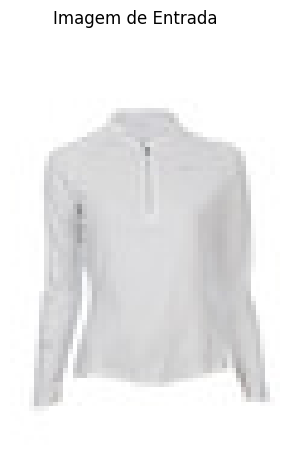

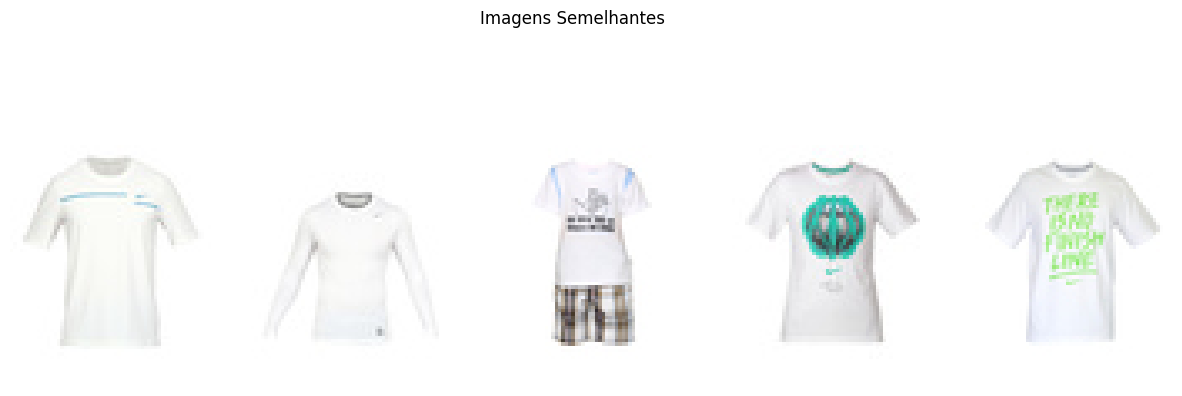

In [18]:
query_image = "/content/Fashion_data/categories/Tshirts/10003.jpg"
similar_images = find_similar_images(query_image, image_vectors, image_paths)

show_images([query_image], "Imagem de Entrada")
show_images(similar_images, "Imagens Semelhantes")